In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
from matplotlib import font_manager, rc

import random
import os
import numpy as np
from collections      import deque
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Dense
from tensorflow.keras.optimizers import Adam

In [11]:
class Agent():
    def __init__(self, state_size, action_size):
        self.weight_backup      = "testroom.h5" # testroom.h5 / "pretrained.h5"
        
        self.state_size         = state_size
        self.action_size        = action_size
        self.memory             = deque(maxlen=1000)

        self.learning_rate      = 0.005
        self.gamma              = 0.9
        
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.005
        self.exploration_decay  = 0.9
        self.brain              = self._build_model()
        

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(20, input_dim=self.state_size, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        

        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = 0.005
            print('model loaded')
            
        return model
    
    def save_model(self):
            self.brain.save(self.weight_backup)

    def act(self, state): # array의 index와 실제 action의 값이 다를때 주의!
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size) -3 
        
        act_values = self.brain.predict(state)
        return np.argmax(act_values[0]) -3 

    def remember(self, state, action, reward, next_state, done): # 상태를 저장
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, sample_batch_size, index):
        if len(self.memory) < sample_batch_size: # sample_batch_size 마다 했던 게임들을 바탕으로 학습
            return
        
        # 일반 게임
        sample_batch = random.sample(self.memory, sample_batch_size) # 일부를 선택

        X_lst = []
        y_lst = []
        for state, action, reward, next_state, done in sample_batch:
            target = reward 
            if not done: #게임 끝이 아니라면 (진행중인경우)
                target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0]) # 큐함수
            target_f = self.brain.predict(state) # 예측값

            target_f[0][action+3] = target # 예측 행동의 q값을 (보상+다음상황에서의 )
            X_lst.append(state)
            y_lst.append(target_f)

            self.brain.fit(state,target_f, epochs=1, verbose=0)
            
        # decay
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay
        if self.exploration_rate <= self.exploration_min:
            self.learning_rate = 0.001

In [12]:
class Room :
    def __init__(self, season, climate, room_size, room_default, limit):
        self.season         = season
        self.climate        = climate
        self.room_size      = room_size
        self.room_default   = room_default
        self.limit          = limit
        
        self.sample_batch_size = 32
        self.episodes          = 500

        self.state_size        = 5
        self.action_size       = 7
        self.agent             = Agent(self.state_size, self.action_size)
        
    def avg_env(self, hour) :
        
        # 계절별 일/낮/밤 평균 기온
        tmp_dict = {'spring' : [13,18,11],
                   'summer' : [26,31,24],
                   'autumn' : [10,13,7],
                   'winter' : [2,4,-8]}
        
        # 계절별 평균 상대 습도
        hum_dict = {'spring' : 55.6,
                   'summer' : 71,
                   'autumn' : 53.7,
                   'winter' : 62.5}
        
        re1 = tmp_dict[self.season][0]
        re2 = hum_dict[self.climate]
        
        return re1, re2
        
    def numofpeople(self, num) : # 
        re1 = 1 +( 0.5 * (num/self.room_size) * 36.5 )
        re2 = 60 +( 0.5 * (num/self.room_size) * 70)  # 습도에 대한 영향은 매우 미비하게
        
        return re1, re2
        
    def room_controller (self, set_temp, cnt, now1, now2) :
        '''
        set_temp : -3 ~ 3
        cnt : 냉난방을 가동한 시간
        re : 방에 가하는 에너지의 정량화
        '''
        
        elec = 10
        
        if set_temp < 0 :
            now_set = 'cool'
            if cnt == 0 :
                elec = -set_temp * 45
            elif cnt >= 1 :
                elec = -set_temp * 30 * (1 + cnt/1000)
                
        elif set_temp > 0 :
            now_set = 'heat'
            if cnt == 0 :
                elec = set_temp * 70
            else :
                elec = set_temp * 45 * (1 + cnt/800)
                
        expenditure = elec * (abs(set_temp)+1)         
        re1 = now1 + (set_temp *(15/(self.room_size+1)))
        re2 = now2 - (20 *(1/(self.room_size+1)))
        
        return expenditure, re1, re2
    
    def cal_condition (self, now1,now2, base_re1, base_re2, human_re1, human_re2, controll_re1, controll_re2) :
        
        def non_zero(val,dv) :
            if val <= 15 :
                return dv
            return val
        
        human_re1 = non_zero(human_re1, now1)
        human_re2 = non_zero(human_re2, now2)
        controll_re1 = non_zero(controll_re1, now1)
        controll_re2 = non_zero(controll_re2, now2)
        
        random_ratio = ((random.randrange(-5,6)) / 100) +1
        
        #print('\nanalysis:')
        #print(f'temp_impact : {(now1)}, {(base_re1)}, {(human_re1 )}, {(controll_re1)}')
        #print(f'hmd_impact : {(now2)}, {(base_re2 )}, {(human_re2)}, {(controll_re2)}')
        #print('\n')
        total_re1 = ((now1 * 0.2) + (base_re1 * 0.1) + (human_re1 * 0.2 )  + (controll_re1 * 0.5) ) * random_ratio
        total_re2 = ((now2 * 0.4) + (base_re2 * 0.15) + (human_re2 * 0.05) + (controll_re2 * 0.4)) * random_ratio
        
        #print(total_re1, total_re2)
        return total_re1, total_re2
 

In [13]:
def run (situation) :
    record = {'part' : [], 'epi' : [], 'exp' : [], 'time' : []}
    replay_cnt = 0
    part = 0
    try :    
        for episode in range(200) :
            done = False
            
            inroom_temp = situation.room_default
            inroom_hmd = 60
            inroom_people = 5

            outdoor_temp, outdoor_hmd = situation.avg_env(0)

            cnt = 0
            totalexp = 0
            total_time= 0
            
            while not done :
                
                # 에이전트의 행동선택
                #print(f'now state : \n1)outdoor : {outdoor_temp}, {outdoor_hmd}\n2)inroom : {up_temp}, {up_hmd}, {inroom_people} people\n*****')
        
                state = [inroom_temp, inroom_hmd, inroom_people, 
                         outdoor_temp, outdoor_hmd]
            
                state = np.reshape(state, [1, situation.state_size]) # 입력 데이터 양식에 맞게 변경
                action = situation.agent.act(state) 
                
                # 행동에 따른 전기세 및 체감쾌적도 계산
                intemp, in_hmd = situation.numofpeople(inroom_people)
                upexp, erg_temp, erg_hmd = situation.room_controller(action, cnt,inroom_temp,inroom_hmd )
                
                totalexp += upexp
                if action != 0 : cnt += 1
                elif action == 0 : cnt = 0 
                    
                #print(f'냉난방 가동 시간 {cnt}')   

                # 다음 상태 계산
                up_temp, up_hmd = situation.cal_condition(inroom_temp,inroom_hmd,outdoor_temp,outdoor_hmd, intemp, in_hmd, erg_temp, erg_hmd )
                if up_temp < situation.limit[0][0] or up_temp > situation.limit[0][1] :
                    #print('too hot or too cold!')
                    done = True
                if up_hmd < situation.limit[1][0] or up_hmd > situation.limit[1][1] :
                    #print('too dry or too wet!')
                    done = True
                    
                total_time +=1
                totalexp += upexp
                
                # 방안의 사람 수 변화
                people_chg = random.randrange(-2,3)
                if inroom_people + people_chg <= situation.room_size and inroom_people + people_chg >= 0 :
                    inroom_people += people_chg
                    
                # 다음 상태 업데이트
                reward = total_time * 1000 - (5 * totalexp/total_time) - ((totalexp/total_time) * done * 10000/total_time )
                next_state = [up_temp, up_hmd, inroom_people,outdoor_temp, outdoor_hmd]
                next_state = np.reshape(next_state, [1, situation.state_size]) # 다음 상태를 다시 입력 데이터 양식으로
                situation.agent.remember(state, action, reward, next_state, done) # 결과를 저장
                if total_time >= 500 :
                    done = True
                
            print("Episode #{} : round : {} / average_budget: {}".format(episode, total_time, round((totalexp)/total_time , 2)))
            
            replay_cnt += total_time
            if replay_cnt >= 32 :
                situation.agent.replay(situation.sample_batch_size, total_time) 
                replay_cnt = 0
                
            record['part'].append(part+1) ;
            record['epi'].append(episode+1) 
            record['exp'].append(round(totalexp/total_time,2)) 
            record['time'].append(total_time)
            
            if episode % 5 == 0 and episode != 0 :
                part += 1
                print(f'\n---part{part} Exploration_Rate : {round(situation.agent.exploration_rate,5)} ---')
                avgs = np.mean(record['exp'][-5:])
                goal = np.mean(record['time'][-5:])
                print(f'---part{part} avg_time : {goal} || exp : {avgs} ---\n')
                if goal >= 250 :
                    print('agent reaches goal!')
                    break    
            
            
    finally:
            situation.agent.save_model()
            print('saved model')
            vis = pd.DataFrame(data = record).groupby('part').mean().reset_index()
            print(vis)
            sns.lineplot(data = vis, x = 'part', y= 'exp', color = 'red')
            ax2 = plt.twinx()
            sns.lineplot(data = vis, x = 'part', y= 'time', color = 'blue', ax= ax2)

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Episode #0 : round : 9 / average_budget: 465.46
Episode #1 : round : 8 / average_budget: 543.15
Episode #2 : round : 9 / average_budget: 600.27
Episode #3 : round : 10 / average_budget: 476.33
Episode #4 : round : 3 / average_budget: 480.69
Episode #5 : round : 1 / average_budget: 1680.0

---part1 Exploration_Rate : 0.9 ---
---part1 avg_time : 6.2 || exp : 756.088 ---

Episode #6 : round : 1 / average_budget: 20.0
Episode #7 : round : 11 / average_budget: 385.14
Episode #8 : round : 3 / average_budget: 427.12
Episode #9 : round : 8 / average_budget: 180.1
Episode #10 : round : 3 / average_budget: 600.9

---part2 Exploration_Rate : 0.9 ---
---part2 avg_time : 5.2 || exp : 322.652 ---

Episode #11 : round : 12 / average_budget: 670.32
Episode #12 : round : 2 / average_budget: 150.0
Episode #13 : round : 1 / average_budget: 1680.0
Episode #14 : round : 9 / average_budget: 536.21
Episode #15 : round : 2 / average_budget: 1080.67

---part3 Exploration_Rate : 0.81 ---
---part3 avg_time : 5.2

Episode #121 : round : 69 / average_budget: 124.95
Episode #122 : round : 184 / average_budget: 131.31
Episode #123 : round : 299 / average_budget: 126.54
Episode #124 : round : 202 / average_budget: 132.36
Episode #125 : round : 76 / average_budget: 133.68

---part25 Exploration_Rate : 0.00464 ---
---part25 avg_time : 166.0 || exp : 129.76800000000003 ---

Episode #126 : round : 486 / average_budget: 149.22
Episode #127 : round : 186 / average_budget: 137.37
Episode #128 : round : 292 / average_budget: 139.66
Episode #129 : round : 45 / average_budget: 123.97
Episode #130 : round : 188 / average_budget: 135.03

---part26 Exploration_Rate : 0.00464 ---
---part26 avg_time : 239.4 || exp : 137.05 ---

Episode #131 : round : 97 / average_budget: 129.0
Episode #132 : round : 500 / average_budget: 153.69
Episode #133 : round : 110 / average_budget: 127.09
Episode #134 : round : 144 / average_budget: 129.0
Episode #135 : round : 337 / average_budget: 140.9

---part27 Exploration_Rate : 0.004

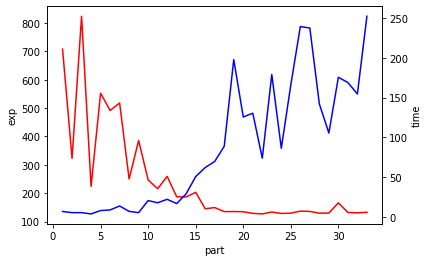

In [14]:
env1 = Room('summer', 'summer', 20, 25, ((22,26), (40,80)))
run(env1)

### pre-trained

# 

In [3]:

class Agent():
    def __init__(self, state_size, action_size):
        self.weight_backup      = "pretrained.h5" # testroom.h5 / "pretrained.h5"
        
        self.state_size         = state_size
        self.action_size        = action_size
        self.memory             = deque(maxlen=1000)

        self.learning_rate      = 0.005
        self.gamma              = 0.9
        
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.005
        self.exploration_decay  = 0.9
        self.brain              = self._build_model()
        

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(21, input_dim=self.state_size, activation='relu'))
        model.add(Dense(14, activation='relu'))
        model.add(Dense(7, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        

        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = 0.005
            print('model loaded')
            
        return model
    
    def save_model(self):
            self.brain.save(self.weight_backup)

    def act(self, state): # array의 index와 실제 action의 값이 다를때 주의!
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size) -3 
        
        act_values = self.brain.predict(state)
        return np.argmax(act_values[0]) -3 

    def remember(self, state, action, reward, next_state, done): # 상태를 저장
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, sample_batch_size, index):
        if len(self.memory) < sample_batch_size: # sample_batch_size 마다 했던 게임들을 바탕으로 학습
            return
        
        # 일반 게임
        sample_batch = random.sample(self.memory, sample_batch_size) # 일부를 선택

        X_lst = []
        y_lst = []
        for state, action, reward, next_state, done in sample_batch:
            target = reward 
            if not done: #게임 끝이 아니라면 (진행중인경우)
                target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0]) # 큐함수
            target_f = self.brain.predict(state) # 예측값

            target_f[0][action+3] = target # 예측 행동의 q값을 (보상+다음상황에서의 )
            X_lst.append(state)
            y_lst.append(target_f)

            self.brain.fit(state,target_f, epochs=1, verbose=0)
            
        # decay
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

In [9]:
# human guide

def run2 (situation) :
    record = {'part' : [], 'epi' : [], 'exp' : [], 'time' : []}
    replay_cnt = 0
    part = 0
    try :    
        for episode in range(15) :
            done = False
            
            inroom_temp = situation.room_default
            inroom_hmd = 60
            inroom_people = 5

            outdoor_temp, outdoor_hmd = situation.avg_env(0)

            cnt = 0
            totalexp = 0
            total_time= 0
            
            while not done :
                
                # 에이전트의 행동선택
                state = [inroom_temp, inroom_hmd, inroom_people, 
                         outdoor_temp, outdoor_hmd]
            
                state = np.reshape(state, [1, situation.state_size]) # 입력 데이터 양식에 맞게 변경
                
                if totalexp == 0 :
                    action = -2
                else :
                    if up_temp >= 25 :
                        action = -3
                    elif up_temp >= 24 :
                        action = -2
                    elif up_temp >= 23.3 :
                        action = -1
                    else :
                        action = 0
                        
                
                # 행동에 따른 전기세 및 체감쾌적도 계산
                intemp, in_hmd = situation.numofpeople(inroom_people)
                upexp, erg_temp, erg_hmd = situation.room_controller(action, cnt,inroom_temp,inroom_hmd )
                
                totalexp += upexp
                if action != 0 : cnt += 1
                elif action == 0 : cnt = 0 
                    
                #print(f'냉난방 가동 시간 {cnt}')   

                # 다음 상태 계산
                up_temp, up_hmd = situation.cal_condition(inroom_temp,inroom_hmd,outdoor_temp,outdoor_hmd, intemp, in_hmd, erg_temp, erg_hmd )
                if up_temp < situation.limit[0][0] or up_temp > situation.limit[0][1] :
                    #print('too hot or too cold!')
                    done = True
                if up_hmd < situation.limit[1][0] or up_hmd > situation.limit[1][1] :
                    #print('too dry or too wet!')
                    done = True
                    
                total_time +=1
                totalexp += upexp
                
                # 방안의 사람 수 변화
                people_chg = random.randrange(-2,3)
                if inroom_people + people_chg <= situation.room_size and inroom_people + people_chg >= 0 :
                    inroom_people += people_chg
                    
                # 다음 상태 업데이트
                reward = total_time * 100 
                next_state = [up_temp, up_hmd, inroom_people,outdoor_temp, outdoor_hmd]
                next_state = np.reshape(next_state, [1, situation.state_size]) # 다음 상태를 다시 입력 데이터 양식으로
                situation.agent.remember(state, action, reward, next_state, done) # 결과를 저장
                if total_time >= 500 :
                    done = True
                    
                
                
            print("Episode #{} : round : {} / average_budget: {}".format(episode, total_time, round(totalexp/total_time,2)))
            situation.agent.replay(situation.sample_batch_size, total_time) 
            replay_cnt = 0
            
                
        print('-' * 15, 'pretrain over', '-' * 15)
        situation.agent.exploration_rate = 0.3
        
        record = {'part' : [], 'epi' : [], 'exp' : [], 'time' : []}
        replay_cnt = 0
        part = 0
        
        for episode in range(200) :
            done = False
            inroom_temp = situation.room_default
            inroom_hmd = 60
            inroom_people = 5
            outdoor_temp, outdoor_hmd = situation.avg_env(0)
            cnt = 0
            totalexp = 0
            total_time= 0
            while not done :
                
                # 에이전트의 행동선택
                #print(f'now state : \n1)outdoor : {outdoor_temp}, {outdoor_hmd}\n2)inroom : {up_temp}, {up_hmd}, {inroom_people} people\n*****')
        
                state = [inroom_temp, inroom_hmd, inroom_people, 
                         outdoor_temp, outdoor_hmd]
            
                state = np.reshape(state, [1, situation.state_size]) # 입력 데이터 양식에 맞게 변경
                action = situation.agent.act(state) 
                
                # 행동에 따른 전기세 및 체감쾌적도 계산
                intemp, in_hmd = situation.numofpeople(inroom_people)
                upexp, erg_temp, erg_hmd = situation.room_controller(action, cnt,inroom_temp,inroom_hmd )
                
                totalexp += upexp
                if action != 0 : cnt += 1
                elif action == 0 : cnt = 0 
                    
                #print(f'냉난방 가동 시간 {cnt}')   

                # 다음 상태 계산
                up_temp, up_hmd = situation.cal_condition(inroom_temp,inroom_hmd,outdoor_temp,outdoor_hmd, intemp, in_hmd, erg_temp, erg_hmd )
                if up_temp < situation.limit[0][0] or up_temp > situation.limit[0][1] :
                    #print('too hot or too cold!')
                    done = True
                if up_hmd < situation.limit[1][0] or up_hmd > situation.limit[1][1] :
                    #print('too dry or too wet!')
                    done = True
                    
                total_time +=1
                totalexp += upexp
                
                # 방안의 사람 수 변화
                people_chg = random.randrange(-2,3)
                if inroom_people + people_chg <= situation.room_size and inroom_people + people_chg >= 0 :
                    inroom_people += people_chg
                    
                # 다음 상태 업데이트
                reward = total_time * 1000 - (5 * totalexp/total_time) - ((totalexp/total_time) * done * 10000/total_time )
                next_state = [up_temp, up_hmd, inroom_people,outdoor_temp, outdoor_hmd]
                next_state = np.reshape(next_state, [1, situation.state_size]) # 다음 상태를 다시 입력 데이터 양식으로
                situation.agent.remember(state, action, reward, next_state, done) # 결과를 저장
                if total_time >= 500 :
                    done = True
                
            print("Episode #{} : round : {} / average_budget: {}".format(episode, total_time, round((totalexp)/total_time , 2)))
            
            replay_cnt += total_time
            if replay_cnt >= 32 :
                situation.agent.replay(situation.sample_batch_size, total_time) 
                replay_cnt = 0
                
            record['part'].append(part+1) ;
            record['epi'].append(episode+1) 
            record['exp'].append(round(totalexp/total_time,2)) 
            record['time'].append(total_time)
            
            if episode % 5 == 0 and episode != 0 :
                part += 1
                print(f'\n---part{part} Exploration_Rate : {round(situation.agent.exploration_rate,5)} ---')
                avgs = np.mean(record['exp'][-5:])
                goal = np.mean(record['time'][-5:])
                print(f'---part{part} avg_time : {goal} || exp : {avgs} ---\n')
                if goal >= 250 :
                    print('agent reaches goal!')
                    break    
            
            
    finally:
            situation.agent.save_model()
            print('saved model')
            vis = pd.DataFrame(data = record).groupby('part').mean().reset_index()
            print(vis)
            sns.lineplot(data = vis, x = 'part', y= 'exp', color = 'red')
            ax2 = plt.twinx()
            sns.lineplot(data = vis, x = 'part', y= 'time', color = 'blue', ax= ax2)

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Episode #0 : round : 78 / average_budget: 391.99
Episode #1 : round : 26 / average_budget: 325.54
Episode #2 : round : 52 / average_budget: 392.36
Episode #3 : round : 68 / average_budget: 362.86
Episode #4 : round : 28 / average_budget: 256.93
Episode #5 : round : 43 / average_budget: 384.92
Episode #6 : round : 14 / average_budget: 428.11
Episode #7 : round : 12 / average_budget: 428.72
Episode #8 : round : 72 / average_budget: 405.76
Episode #9 : round : 9 / average_budget: 330.0
Episode #10 : round : 83 / average_budget: 376.75
Episode #11 : round : 141 / average_budget: 412.12
Episode #12 : round : 44 / average_budget: 385.6
Episode #13 : round : 70 / average_budget: 398.67
Episode #14 : round : 7 / average_budget: 408.97
--------------- pretrain over ---------------
Episode #0 : round : 22 / average_budget: 384.78
Episode #1 : round : 11 / average_budget: 339.77
Episode #2 : round : 9 / average_budget: 682.71
Episode #3 : round : 30 / average_budget: 739.05
Episode #4 : round : 2

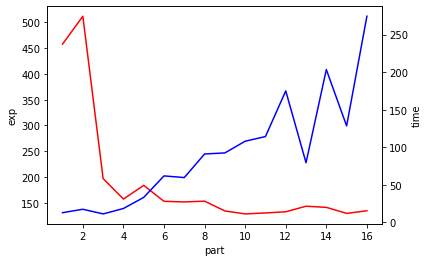

In [10]:
env2 = Room('summer', 'summer', 20, 25, ((22,26), (40,80)))
run2(env2) 

## 

In [9]:
(80 + 500 + 275 + 382 + 189) / 5

285.2